# GLM Example Usage: Auditory Stimulation

We will use a General Linear Model to compare the fMRI signal during periods of auditory stimulation versus periods of rest.

## Workflow

1. **Defining stimulus events:** the **`events.tsv`** file in the dataset defines the timing of the auditory stimulation and rest periods. We create an **`events`** dataframe from the data in the **`events.tsv`** file.

2. **Building the design matrix:** we use the Nilearn **`FirstLevelModel`** class to set the parameters of the design matrix.

3. **Model fitting:** we use the **`fit`** method of the **`FirstLevelModel`** class to build the design matrix and fit the model using the information provided by the **`events`** dataframe.

4. **Statistical inference (Contrasts):** we creat a contrast for `listening > rest`. A T-test allows to see if the difference in Beta weights is statistically significant compared to the noise (residuals).

5. **Results:** the analysis generates a Statistical Parametric Map, highlighting areas if the "listening" regressor significantly outweighs the "rest" regressor.

## Install Nilearn

In [ ]:
!pip install -q nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 77.7 MB/s eta 0:00:00


## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Retrieving the Dataset

We use a single-subject auditory fMRI dataset originally provided by SPM (Statistical Parametric Mapping).

In [ ]:
from nilearn.datasets import fetch_spm_auditory

# download the auditory dataset
subject_data = fetch_spm_auditory()

[fetch_spm_auditory] Added README.md to /root/nilearn_data

[fetch_spm_auditory] Dataset created in /root/nilearn_data/spm_auditory

[fetch_spm_auditory] Data absent, downloading...

[fetch_spm_auditory] Downloading data from 
https://www.fil.ion.ucl.ac.uk/spm/download/data/MoAEpilot/MoAEpilot.bids.zip ...

[fetch_spm_auditory] Downloaded 3923968 of 30176409 bytes (13.0%%,    6.7s remaining)

[fetch_spm_auditory] Downloaded 8019968 of 30176409 bytes (26.6%%,    5.6s remaining)

[fetch_spm_auditory] Downloaded 12427264 of 30176409 bytes (41.2%%,    4.3s remaining)

[fetch_spm_auditory] Downloaded 17047552 of 30176409 bytes (56.5%%,    3.1s remaining)

[fetch_spm_auditory] Downloaded 21495808 of 30176409 bytes (71.2%%,    2.0s remaining)

[fetch_spm_auditory] Downloaded 26058752 of 30176409 bytes (86.4%%,    1.0s remaining)

[fetch_spm_auditory]  ...done. (8 seconds, 0 min)

[fetch_spm_auditory] Extracting data from /root/nilearn_data/spm_auditory/MoAEpilot.bids.zip...

[fetch_spm_auditory] .. done.

## Inspecting the Dataset

Print the path of func image:

In [ ]:
subject_data.func[0]

'/root/nilearn_data/spm_auditory/MoAEpilot/sub-01/func/sub-01_task-auditory_bold.nii'

We display the mean functional image and the subject's anatomy:

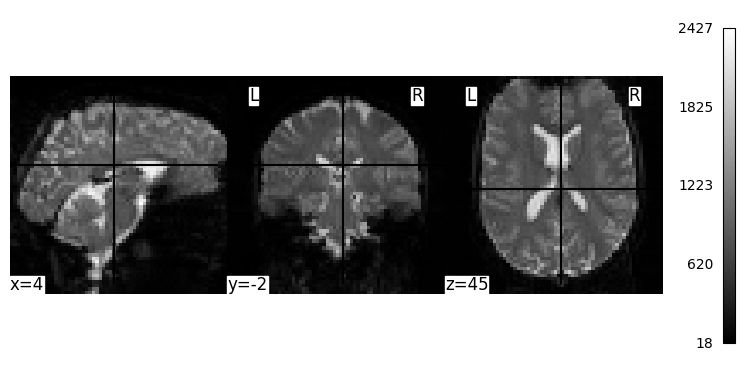

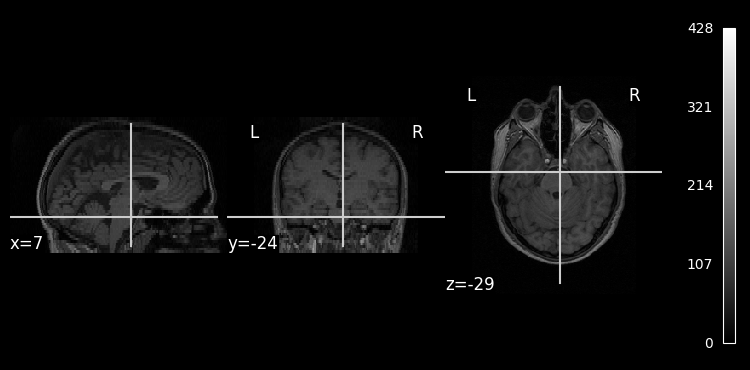

In [ ]:
from nilearn.image import mean_img
from nilearn.plotting import plot_anat, plot_img, plot_stat_map

# functional image
fmri_img = subject_data.func

# mean functional image
mean_img = mean_img(subject_data.func[0])

# plot mean functional image
plot_img(mean_img, cbar_tick_format="%i")

# plot anatomical image
plot_anat(subject_data.anat, cbar_tick_format="%i")

## Defining Stimulus Events

The stimulus events are defined in the **`events.tsv`** file in the dataset, which defines the timing of the auditory stimulation and rest periods.

We create an **`events`** dataframe from the data in the **`events.tsv`** file.

In [ ]:
# create dataframe of events
events = pd.read_table(subject_data.events)

events

,onset,duration,trial_type
0,42,42,listening
1,126,42,listening
2,210,42,listening
3,294,42,listening
4,378,42,listening
5,462,42,listening
6,546,42,listening


## Performing the GLM Analysis

### Setting Parameters of Design Matrix

We use the Nilearn **`FirstLevelModel`** class to set the parameters of the design matrix.

We set the parameters of the first-level model as follows:

* **`t_r=7`**: we set the repetition time in seconds.
* **`noise_model='ar1'`** we set the noise model to AR(1), autoregressive process of order 1.
* **`standardize=False`** we do not rescale the time series to mean 0, variance 1.
* **`hrf_model='spm'`** we use the SPM canonical HRF model.
* **`drift_model='cosine'`** we model the signal drifts as slow oscillating time functions
* **`high_pass=0.01`** defines the cutoff frequency in Hz.

The **`drift_model`** parameter is used to account for low-frequency noise (e.g., scanner drift). Options include 'cosine' (default) or 'polynomial'.

The number of drift regressors included in the design matrix for **`drift_model='cosine'`** is calculated to cover all frequencies below the **`high_pass`** cutoff.
* Calculation: The number of cosine terms is roughly<br>
$2 \times \text{duration} \times \text{high_pass} +1$ (including the constant).
* Example: For a 10-minute scan (600s) and a 0.01 Hz cutoff, you might see 12 drift columns in addition to the constant.

In [ ]:
from nilearn.glm.first_level import FirstLevelModel

# set parameters of design matrix
fmri_glm = FirstLevelModel(
    t_r=subject_data.t_r,
    noise_model="ar1",
    standardize=False,
    hrf_model="spm",
    drift_model="cosine",
    high_pass=0.01,
    verbose=1,
    minimize_memory=False
)


### Fitting the Model

We use the **`fit`** method of the **`FirstLevelModel`** class to build the design matrix and fit the model using the information provided by the **`events`** dataframe.

In [ ]:
# fit the GLM model
fmri_glm = fmri_glm.fit(fmri_img, events)

[FirstLevelModel.fit] Loading data from 
'/root/nilearn_data/spm_auditory/MoAEpilot/sub-01/func/sub-01_task-auditory_bold.nii'

[FirstLevelModel.fit] Computing mask

[FirstLevelModel.fit] Resampling mask

[FirstLevelModel.fit] Finished fit

[FirstLevelModel.fit] Computing run 1 out of 1 runs (go take a coffee, a big one).

[FirstLevelModel.fit] Performing mask computation.

[FirstLevelModel.fit] Loading data from <nibabel.nifti1.Nifti1Image object at 0x794b817bf8c0>

[FirstLevelModel.fit] Extracting region signals

[FirstLevelModel.fit] Cleaning extracted signals

[FirstLevelModel.fit] Masking took 1 seconds.

[FirstLevelModel.fit] Performing GLM computation.

[FirstLevelModel.fit] GLM took 3 seconds.

[FirstLevelModel.fit] Computation of 1 runs done in 5 seconds.

### Display the Design Matrix

The **`FirstLevelModel`** class provides the following attribute:
* **`design_matrices_`**: A list of pandas DataFrame objects, one for each run, that were actually used in the GLM fitting process.

The model is implictily meant to for multiple runs, but in our case the model computes only one run.

We take the first design matrix:

In [ ]:
# get the design matrix
design_matrix = fmri_glm.design_matrices_[0]

We display the design matrix: rows represent time (scans), and columns contain the predictors:

<Axes: label='conditions', ylabel='scan number'>

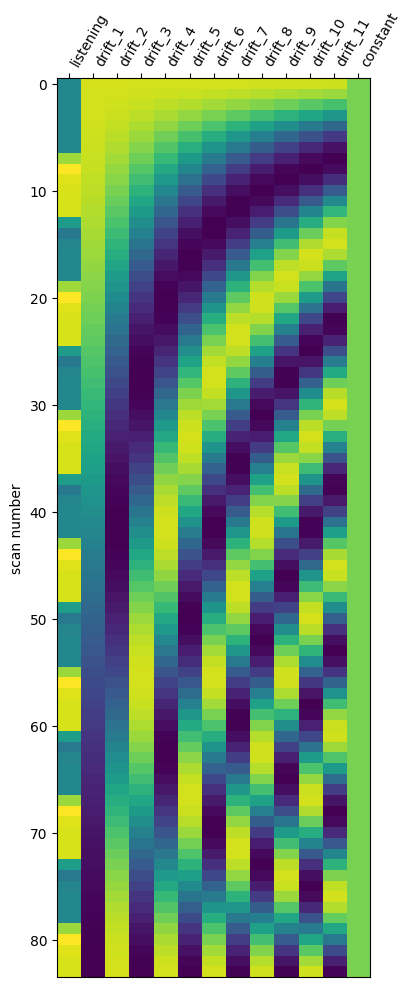

In [ ]:
from nilearn.plotting import plot_design_matrix

# plot the design matrix
plot_design_matrix(design_matrix)

### Save the Design Matrix to Disc

In [ ]:
# save design matrix to disc
plot_design_matrix(design_matrix, output_file='design_matrix.png')

### Plot the Expected Response

The first column of the design matrix contains the expected response profile of regions which are sensitive to the auditory stimulation.

We plot this first column:

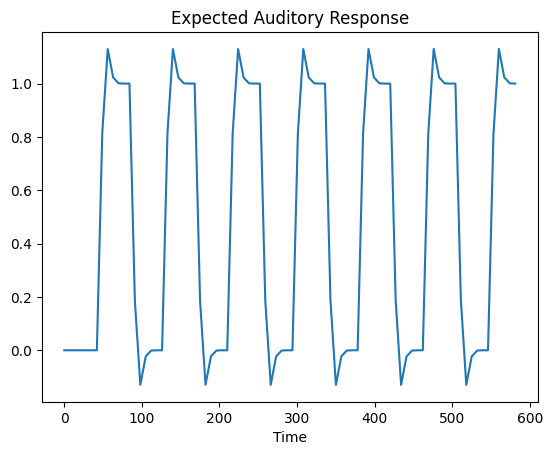

In [ ]:
# plot the first column of the design matrix
plt.plot(design_matrix["listening"])

plt.xlabel("Time")
plt.title("Expected Auditory Response")

plt.show()

## Detecting Voxels With Significant Effects

### Define Contrast

We define a contrast of interest that just considers the effect of the stimulation in isolation.

Here the baseline is implicit, so passing a value of **`1`** for the first column will give contrast for: **`listening > rest`**.

In [ ]:
# create contrast
n_regressors = design_matrix.shape[1]
activation = np.zeros(n_regressors)
activation[0] = 1

We plot the coefficients of the contrast, indexed by the names of the columns of the design matrix.

The Nilearn **`plot_contrast_matrix`** function is a utility used to visualize contrast definitions in the context of General Linear Models.

It specifically helps verify that your contrast vectors or matrices correctly target the intended regressors in your design matrix

<Axes: label='conditions'>

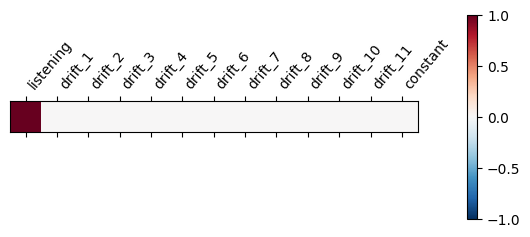

In [ ]:
from nilearn.plotting import plot_contrast_matrix

# plot contrast matrix
plot_contrast_matrix(contrast_def=activation, design_matrix=design_matrix)

### Compute Contrast

We compute a contrast using the **`compute_contrast`** method on the fitted **`FirstLevelModel`** object.

As argument to this method, we provide the contrast vector we previously defined.

This method calculates the statistical significance of the contrast.

The method parameter **`output_type`** determines what the method returns and sets the type of statistical map. Common options include:
* **`'z_score'`**: Standardized map of statistical significance.
* **`'stat'`**: The raw t or F statistic.
* **`'effect_size'`**: The $\beta$ weights/parameter estimates of the contrast.

We create a effect size map:


In [ ]:
# create effect size map
eff_map = fmri_glm.compute_contrast(activation, output_type="effect_size")

[FirstLevelModel.compute_contrast] Computing image from signals

### z-Map

In order to get statistical significance, we form a t-statistic, and directly convert it into a z-score across voxels.

We create a z-score map (z-map):

In [ ]:
# create a z-map
z_map = fmri_glm.compute_contrast(activation, output_type="z_score")

[FirstLevelModel.compute_contrast] Computing image from signals

## Plot Thresholded z-Map

We display the thresholded z-map on top of the average functional image of the series (could be the anatomical image of the subject).

We use arbitrarily a threshold of 3.0 in z-scale.

We show 3 axial views, with **`display_mode='z'`** and **`cut_coords=3`**.

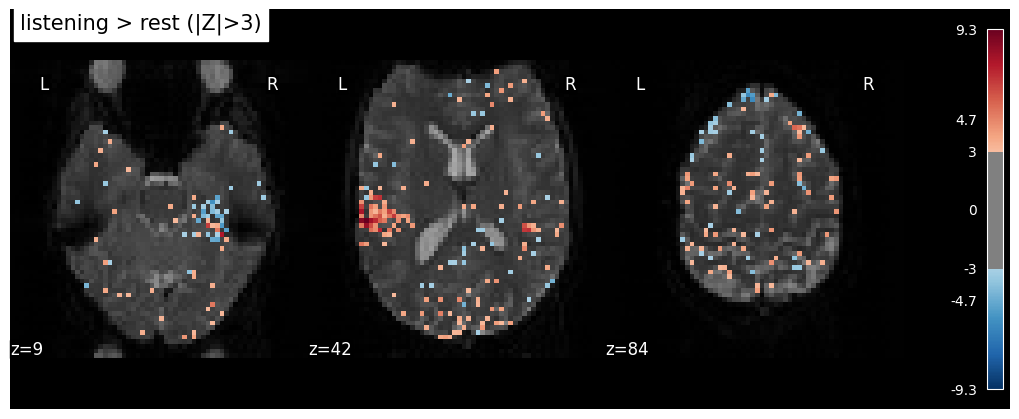

In [ ]:
# configure plotting
plotting_config = {
    "bg_img": mean_img,
    "display_mode": "z",
    "cut_coords": 3,
    "black_bg": True,
}

# plot z-map
plot_stat_map(
    z_map,
    threshold=3,
    title="listening > rest (|Z|>3)",
    figure=plt.figure(figsize=(10, 4)),
    **plotting_config,
)

### Interpreting the Statistical Maps

Once we have generated the statistical maps, it is important to understand how to interpret the visualized results.

In this case, we are working with z-maps, where z-scores indicate how far the observed effect is from the mean, in terms of standard deviations.

### What does a z-score mean?

**Positive and significant z-score:** A z-score greater than 3 ($Z > 3$) indicates significantly higher activation in a specific brain region compared to the reference condition (here, the rest state).<br>
For example, high z-scores in the auditory cortex suggest significant activation during the auditory task.

**Negative z-scores:** Negative z-scores indicate deactivation in that region during the task compared to rest.

Notice how the visualizations above shows both "activated" voxels with $Z > 3$, as well as "deactivated" voxels with $Z < -3$.

In the rest of this example we will show only the activate voxels by using one-sided tests.

## Statistical Significance Testing

A Type I error, or "false positive," occurs in statistics when the null hypothesis $(H_{0})$ is true, but is incorrectly rejected.

This means concluding that a statistically significant effect or difference exists in the population when it actually does not.

It represents a "false alarm" where random chance is misinterpreted as a real, significant result.

We typically apply a statistical threshold (e.g., $Z > 3$) to visualize only the regions showing significant activation.

However, note that this threshold is arbitrary and does not account for the false positive rate (Type I errors).

To correct for this, stricter statistical corrections can be applied to control the false positive rate (denoted by $\alpha$) at a certain level, e.g. setting $\alpha=0.001$ means that there is 0.1% chance of declaring an inactive voxel as active.

The following methods are employed to correct false positive rates:
* False Discovery Rate (FDR).
* Family-Wise Error Rate (FWER), also known as Bonferroni correction.

For instance, an FDR correction with $\alpha = 0.05$ reduces false positives and ensures the observed activations are more robust and reliable.

## Treshold Statistical Maps

The Nilearn **`threshold_stats_img`** is a powerful tool used to threshold statistical maps (typically z-scale images) by applying specific alpha values and multiple comparison corrections.

It translates a desired significance level into a z-scale threshold to produce a mask of significant voxels.

**Key Parameters**

* **`stat_img`**: The input statistical image (Niimg-like) to be thresholded, usually in z-scale.
* **`alpha`**: The significance level (e.g., 0.05 or 0.001) used to control the threshold.
* **`height_control`**: Defines the type of multiple comparisons correction:
    * **`'fpr'`**: False Positive Rate (uncorrected). This is lenient and may result in many false positives.
    * **`'fdr'`**: False Discovery Rate (Benjamini-Hochberg). This controls the proportion of false positives among detections and is commonly advised for reporting results.
    * **`'bonferroni'`**: Family-Wise Error Rate (FWER) correction. This is the most conservative method, significantly reducing false positives but potentially increasing false negatives.
    * **`None`**: Uses a raw z-threshold instead of a p-value.
* **`cluster_threshold`**: Minimum cluster size (in voxels) required for a cluster to be retained in the output.

In the **`height_control`** parameter, **`'fdr'`** is used for more stringent, publication-ready results, while **`'fpr'`** might be used for exploratory purposes.

## Plotting Threshold z-Maps

**Uncorrected**

Plot z-map with **`height_control`** parameter set to **`fpr`** (uncorrected):

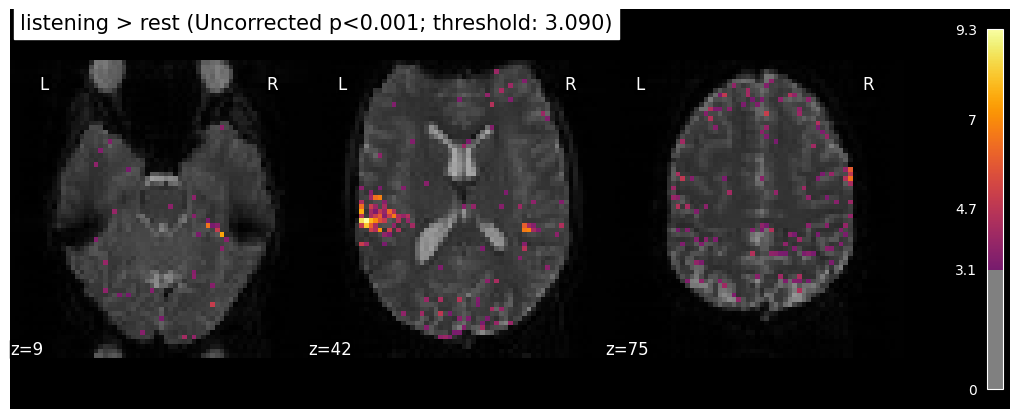

In [ ]:
from nilearn.glm import threshold_stats_img

clean_map, threshold = threshold_stats_img(
    z_map,
    alpha=0.001,
    height_control="fpr",
    two_sided=False,  # using a one-sided test
)

# use a sequential colormap as we will only display positive values.
plotting_config["cmap"] = "inferno"
plot_stat_map(
    clean_map,
    threshold=threshold,
    title=(
        f"listening > rest (Uncorrected p<0.001; threshold: {threshold:.3f})"
    ),
    figure=plt.figure(figsize=(10, 4)),
    **plotting_config,
)

**Bonferroni correction**

Bonferroni correction is a more conservative solution that controls the family wise error rate, i.e. the probability of making only one false detection, say at 5%.

Plot z-map with **`height_control`** parameter set to **`bonferroni`**.

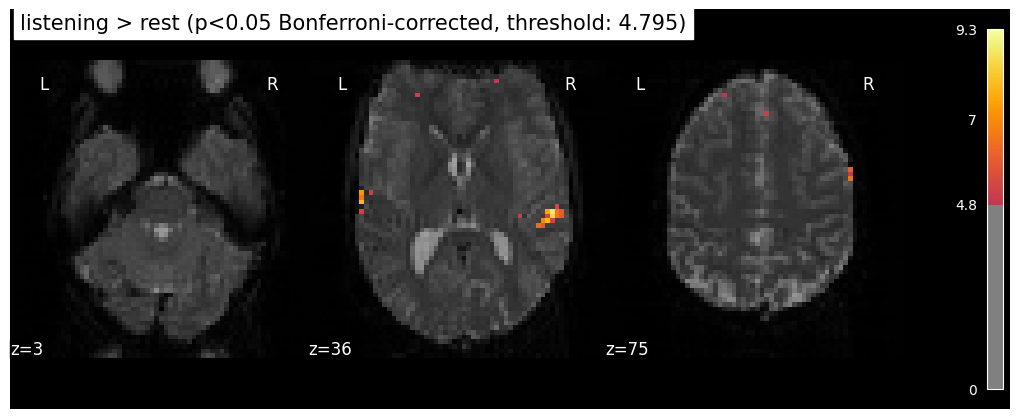

In [ ]:
clean_map, threshold = threshold_stats_img(
    z_map,
    alpha=0.05,
    height_control="bonferroni",
    two_sided=False
)

plot_stat_map(
    clean_map,
    threshold=threshold,
    title=(
        "listening > rest (p<0.05 Bonferroni-corrected, "
        f"threshold: {threshold:.3f})"
    ),
    figure=plt.figure(figsize=(10, 4)),
    **plotting_config,
)

**False Discovery Rate Correction**

FDR correction controls the expected proportion of false discoveries among detections.

Plot z-map with **`height_control`** parameter set to **`fdr`**.

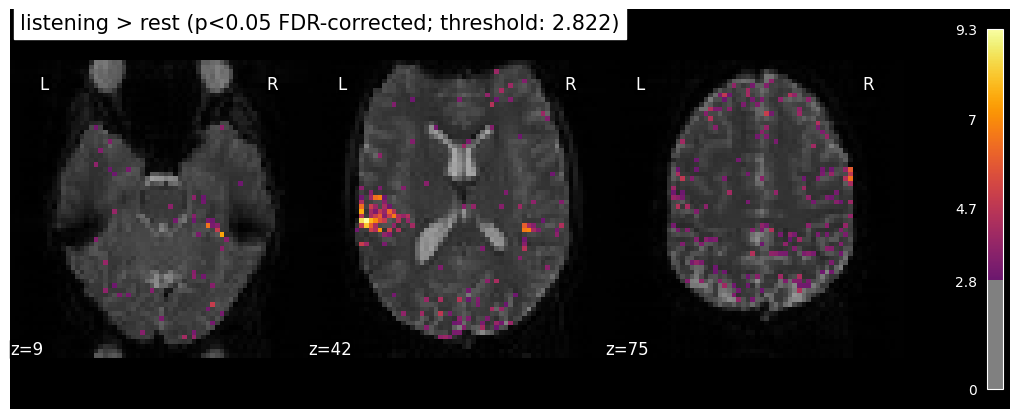

In [ ]:
clean_map, threshold = threshold_stats_img(
    z_map,
    alpha=0.05,
    height_control="fdr",
    two_sided=False
)

plot_stat_map(
    clean_map,
    threshold=threshold,
    title=(
        f"listening > rest (p<0.05 FDR-corrected; threshold: {threshold:.3f})"
    ),
    figure=plt.figure(figsize=(10, 4)),
    **plotting_config,
)

**Activation Clusters**

Cluster treshold allows to discard isolated voxels ("small clusters") from these images.

It is possible to generate a thresholded map with small clusters removed by setting a **`cluster_threshold`** argument.

We apply a 10-voxel threshold was applied to ensure that only sufficiently large and significant clusters are considered.<br>
Clusters smaller than 10 voxels will be discarded.<br>
This helps identify the most relevant brain regions in terms of activation.

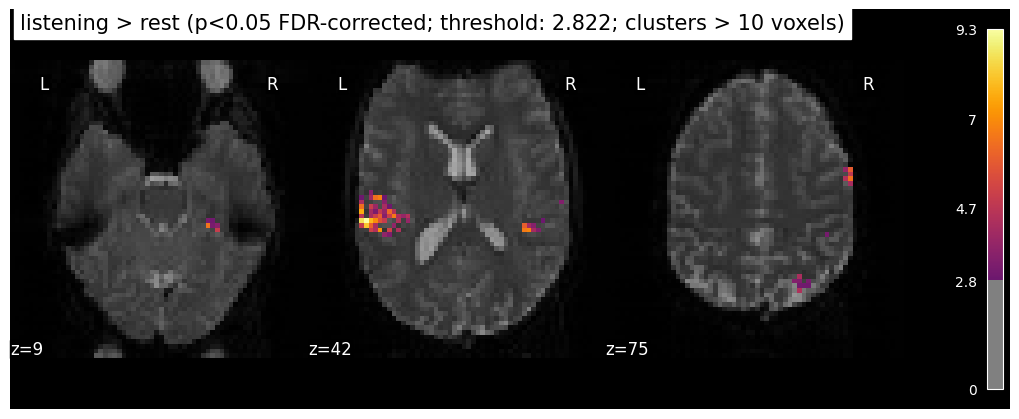

In [ ]:
clean_map, threshold = threshold_stats_img(
    z_map,
    alpha=0.05,
    height_control="fdr",
    cluster_threshold=10,
    two_sided=False,
)

plot_stat_map(
    clean_map,
    threshold=threshold,
    title=(
        "listening > rest "
        f"(p<0.05 FDR-corrected; threshold: {threshold:.3f}; "
        "clusters > 10 voxels)"
    ),
    figure=plt.figure(figsize=(10, 4)),
    **plotting_config,
)

**Save z-map**

We save the effect and z-score maps to the disk:

In [ ]:
z_map.to_filename('listening_gt_rest_z_map.nii.gz')
eff_map.to_filename('listening_gt_rest_eff_map.nii.gz')

**Extract report**

The Nilearn **`get_clusters_table`** function is used to extract a summary table of clusters from a 3D statistical map.

It is typically used after fitting a General Linear Model (GLM) to identify significant brain activations.

**Parameters:**
* **`stat_img`**: A 3D statistical image (e.g., a Z-map or T-map).
* **`stat_threshold`**: The value used to threshold the image and define clusters.
* **`cluster_threshold`**: The minimum number of voxels a cluster must contain to be included in the table.

**Outputs:** A DataFrame with the following default columns:
* **Cluster ID:** A unique identifier for each cluster.
* **X, Y, Z:** MNI coordinates of the cluster's peak or Center of Mass (COM).
* **Peak Stat:** The maximum statistical value within the cluster.
* **Cluster Size (mm³):** The physical volume of the cluster.

We extract a table of clusters:

In [ ]:
from nilearn.reporting import get_clusters_table

table = get_clusters_table(z_map, stat_threshold=threshold, cluster_threshold=20)

table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-60.0,-6.0,42.0,9.341729,3888
1,1a,-51.0,-12.0,39.0,7.952826,
2,1b,-63.0,0.0,42.0,7.595170,
3,1c,-42.0,-12.0,39.0,7.034967,
4,2,60.0,0.0,36.0,8.738699,1620
5,2a,45.0,-12.0,42.0,6.850138,
6,2b,69.0,6.0,30.0,4.062676,
7,3,66.0,15.0,27.0,7.947193,837
8,3a,51.0,3.0,30.0,6.676518,
9,4,36.0,-3.0,15.0,7.945328,1161


## Summary of the Analysis

In our brain activation analysis for the listening versus rest task, we used a General Linear Model (GLM) to study differences in activation.

Through contrast analysis (listening vs. resting), we generated a z-map showing significant brain activation for the auditory task.

The results showed the regions with significantly higher activation when participants were at the auditory task (Z > 3, p < 0.001 uncorrected).

Applying a False Discovery Rate (FDR) correction with a threshold of 0.05, allowed us to show the most involved areas.

Finally, by removing small clusters of fewer than 10 voxels, we observed that the most significant activations remained in key areas, suggesting a robust effect in these regions.

The results were saved a table summarizing the coordinates of voxels with significant activation.

## Performing an F-test

**`listening > rest`** is a typical t-test: condition versus baseline.

Another popular type of test is an F-test, in which one seeks whether a certain combination of conditions (possibly two-, three- or higher-dimensional) explains a significant proportion of the signal.

Here one might for instance test which voxels are well explained by the combination of more active or less active than rest.

As opposed to a t-test, the beta images produced by an F-tests only contain positive values.

We specify the contrast and compute the corresponding map.

Actually, the contrast specification is done exactly the same way as for t-contrasts.

In [ ]:
z_map = fmri_glm.compute_contrast(
    activation,
    output_type="z_score",
    stat_type="F",  # perform an F-test
)

[FirstLevelModel.compute_contrast] Computing image from signals

Note that the statistic has been converted to a z-score, which makes it easier to represent it.

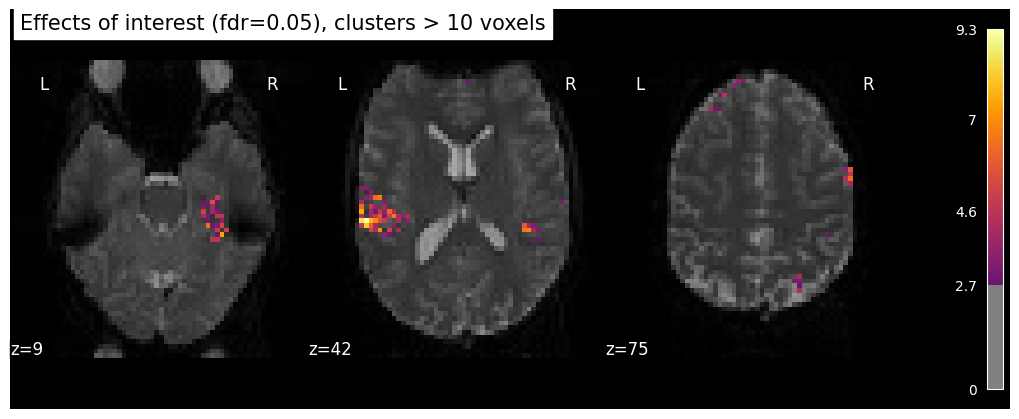

In [ ]:
clean_map, threshold = threshold_stats_img(
    z_map,
    alpha=0.05,
    height_control="fdr",
    cluster_threshold=10,
    two_sided=False,
)

plot_stat_map(
    clean_map,
    threshold=threshold,
    title="Effects of interest (fdr=0.05), clusters > 10 voxels",
    figure=plt.figure(figsize=(10, 4)),
    **plotting_config,
)

## Predicted Time Series

We extract the predicted time series to assess the quality of the model fit.

### Extract the Largest Cluster

We extract the coordinates of the largest cluster from the clusters table we generated previously.

This cluster is in the top row of the table.

To use this coordinates in a masker, the coordinates variable must be a list of triplets:

In [ ]:
# Extract the largest cluster
largest_cluster = table.iloc[0]
coords = [(largest_cluster['X'], largest_cluster['Y'], largest_cluster['Z'])]

### Define a Masker

The **`NiftiSpheresMasker`** is a specialized tool in Nilearn used to extract brain signals from spherical regions of interest (ROIs) centered around specific seed coordinates.

A Masker converts 4D fMRI image data into a 2D array of time series (voxels by time points).

The typical workflow involves three main steps:

1. **Initialization:** Define your seeds (coordinates) and the radius of the spheres.
2. **Fitting:** "Fit" the masker to your data (this validates the coordinates against the image affine).
3. **Transforming:** Extract the time series from your 4D functional images.

We initialize a masker with the coordinates of the largest cluster.

We set the parameter **`standardize='zscore_sample'`** to standardize fMRI images (rescale to zero mean and unit variance).

In [ ]:
from nilearn.maskers import NiftiSpheresMasker

# Define a mask from coordinates to inspect
masker = NiftiSpheresMasker(coords, standardize="zscore_sample", radius=4)

### Extract Signals

A Masker converts 4D fMRI image data into a 2D array of time series (voxels by time points).

We extract the observed and the predicted times series.

In [ ]:
# Extract observed and predicted time series
observed_timeseries = masker.fit_transform(fmri_img[0])
predicted_timeseries = masker.fit_transform(fmri_glm.predicted[0])


[FirstLevelModel.predicted] Computing image from signals

### Plot the Time Series

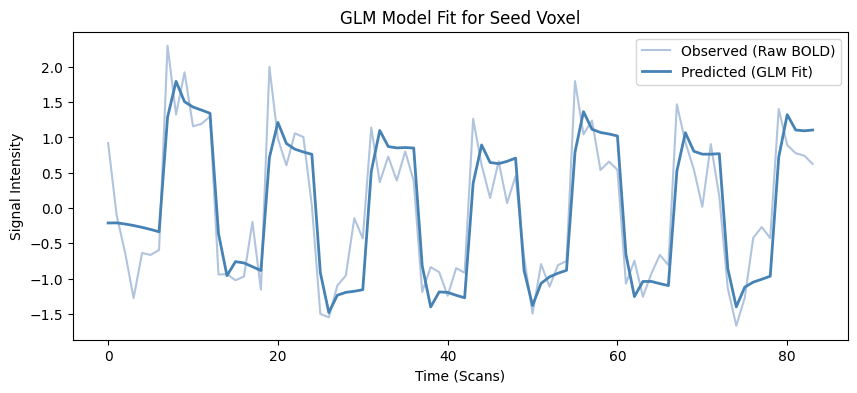

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(observed_timeseries, label='Observed (Raw BOLD)', color='lightsteelblue')
plt.plot(predicted_timeseries, label='Predicted (GLM Fit)', color='steelblue', linewidth=2)
plt.xlabel('Time (Scans)')
plt.ylabel('Signal Intensity')
plt.legend()
plt.title('GLM Model Fit for Seed Voxel')
plt.show()